In [63]:
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
df = pd.read_csv('data/kickstarter-projects/ks-projects-201612.csv', encoding='latin8', header=0) # Kaggle Datas

/Users/rob/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df = df.iloc[:,:-4] # trash cols
df.columns = ('ID name cat main_cat currency deadline goal launched pledged state backers country usd_pledged'.split()) 


In [4]:
df = df[~df['goal'].str.contains('G')] # Tossing rows with misplaced columns
df = df[~df['goal'].str.contains(':')] # Tossing rows with misplaced columns
df = df[~df['goal'].str.contains('U')] # Tossing rows with misplaced columns

df = df[~df['pledged'].str.contains('G')] # Tossing rows with misplaced columns
df = df[~df['pledged'].str.contains(':')] # Tossing rows with misplaced columns
df = df[~df['pledged'].str.contains('U')] # Tossing rows with misplaced columns

In [5]:
df['pledged'] = df['pledged'].astype(float) # Coerce strings to floats
df['goal'] = df['goal'].astype(float)
df['backers'] = df['backers'].values.astype(float)
df['usd_pledged'] = df['usd_pledged'].astype(float)

In [6]:
df = df[df['goal'] >= 3000] # Toss out any projects smaller than 3k

In [7]:
df['goal_log'] = np.log(df['goal']) # Linearize the goal numbers

In [8]:
df['percent_pledged'] = df.pledged / df.goal # Creating a binary "funded" metric
df['funded'] = (df['percent_pledged'] >= 1).astype(float) # Creating a binary "funded" metric

In [9]:
def force_to_datetime(series): # For turning dateTime strings into actual timestamps
    formatted_dates = []
    for date in series:
        formatted_dates.append(datetime.strptime(date,"%Y-%m-%d %H:%M:%S"))
    return (np.array(formatted_dates))

In [10]:
df['deadline'] = force_to_datetime(df['deadline'].values)
df['launched'] = force_to_datetime(df['launched'].values)
df['campaign_duration'] = df['deadline'] - df['launched'] # Creating a campaign duration metric

In [11]:
df['pledge_per_donor'] = df['usd_pledged'] / df['backers'] # Pledge per donor metric
df['pledge_per_donor'] = df['pledge_per_donor'].fillna(0)

In [12]:
# weekdays of launch and deadline
df['weekday_launched'] = df['launched'].dt.weekday_name
df['weekday_end'] = df['deadline'].dt.weekday_name
df = df[df.campaign_duration.astype('timedelta64[D]') <= 300] # solves some timedelta problems

In [13]:
df['campaign_duration_days'] = df.campaign_duration.astype('timedelta64[D]')

In [15]:
# Build features
X = df['main_cat goal_log campaign_duration_days weekday_launched weekday_end'.split()]
X = pd.get_dummies(X)

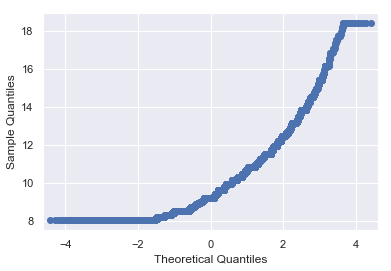

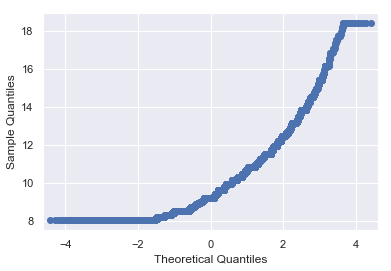

In [16]:
sm.qqplot(X['goal_log'])

In [17]:
y = df.funded

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
model = LogisticRegressionCV(Cs = 100, cv = 4, random_state=42, solver='lbfgs').fit(X,y)

In [48]:
trained_performance = pd.DataFrame(np.abs(model.predict(X_train) - y_train))
tp = trained_performance['funded'].value_counts()
tp

0.0    125327
1.0     51904
Name: funded, dtype: int64

In [49]:
test_results = pd.DataFrame(np.abs(model.predict(X_test) - y_test))
tr = test_results['funded'].value_counts()
tr

0.0    31290
1.0    13018
Name: funded, dtype: int64

In [59]:
y_score = model.decision_function(X_test)

y_train_score = model.decision_function(X_train)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)

AUC: 0.6806959682103078


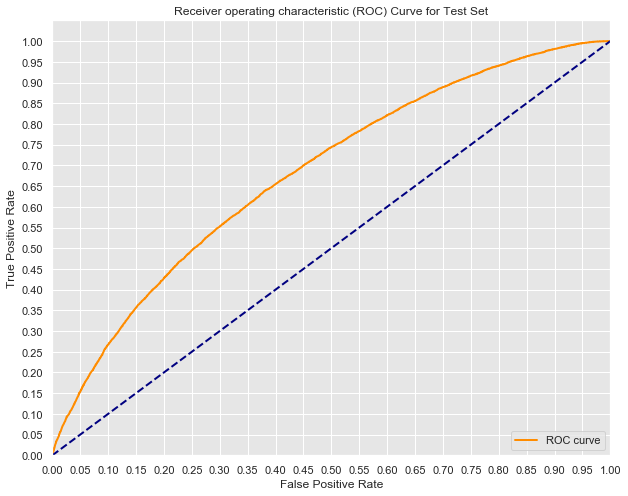

In [60]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Test Set')
plt.legend(loc="lower right")
print('AUC: {}'.format(auc(fpr, tpr)))
plt.show()

AUC: 0.6798464657240968


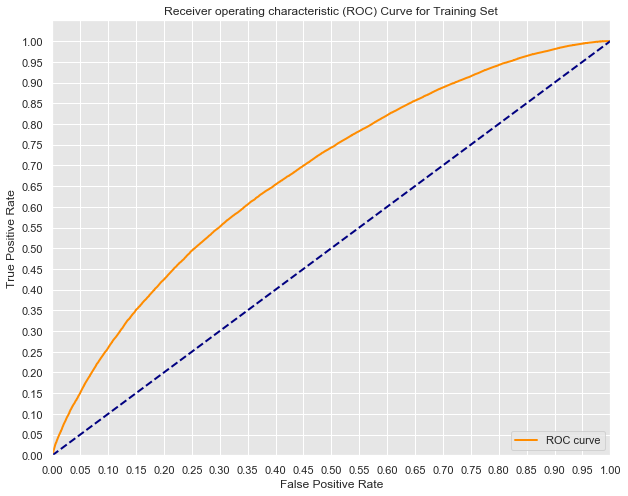

In [61]:
plt.figure(figsize=(10,8))
lw = 2
plt.plot(train_fpr, train_tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Training Set')
plt.legend(loc="lower right")
print('AUC: {}'.format(auc(train_fpr, train_tpr)))
plt.show()

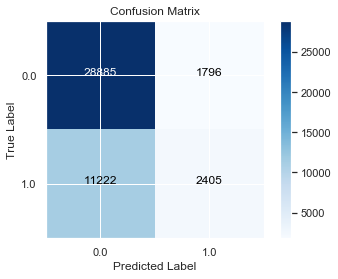

In [64]:
def show_cf(y_true, y_pred, class_names=None, model_name=None):
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    
    if model_name:
        plt.title("Confusion Matrix: {}".format(model_name))
    else:
        plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    class_names = set(y_true)
    tick_marks = np.arange(len(class_names))
    if class_names:
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')

    plt.colorbar()

show_cf(y_test, model.predict(X_test))